<a href="https://colab.research.google.com/github/Graviton12/CS-430-Group-Project/blob/main/cherokee_park_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying Models to Cherokee Park 2024 and 2021 Datasets**

In [ ]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# imports for models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# **Model 1: K-Means Clustering + Random Forest Regressor**

## K-Means Clustering and Random Forest Regressor Models for Cherokee 2024 + 2021 data

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="Olmstead_combined")

In [ ]:
data.head()

,trimble station,average_canopy_cover,canopy,understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,Cherokee1,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,Cherokee2,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,Cherokee3,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,Cherokee4,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,Cherokee5,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#drop last column
data = data.iloc[:, :-1]
#drop understory
data = data.drop(columns=['understory'])
#drop trimble station
data = data.drop(columns=['trimble station'])

In [ ]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum
0,92.98,"Walnut, maple, mulberry, locust",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0
1,98.18,"Cherry, hackberry, maple",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0
2,97.40,"Oak, basswood, maple",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0
3,93.24,"Locust, walnut, sycamore",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0
4,87.00,"Oak, maple, locust",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
numeric_data = data.select_dtypes(include=np.number)

# Create and apply the imputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(numeric_data)


# Update the original DataFrame with imputed values
data[numeric_data.columns] = imputed_data

In [ ]:
# drop the empty canopy rows
data = data.dropna(subset=['canopy'])

In [ ]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }
    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
data['canopy'] = data['canopy'].apply(clean_canopy_as_list_lowercase)


In [ ]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum
0,92.98,"[walnut, maple mulberry, locust]",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0
1,98.18,"[cherry, hackberry, maple]",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0
2,97.40,"[oak, basswood, maple]",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0
3,93.24,"[locust, walnut, sycamore]",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0
4,87.00,"[oak, maple locust]",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_data = data.explode('canopy')

# One-hot encode using pd.crosstab
canopy_crosstab = pd.crosstab(index=exploded_data.index, columns=exploded_data['canopy'])

# Merge the one-hot encoded data back with the original DataFrame
olmstead_encoded = pd.concat([data.drop(columns=['canopy']), canopy_crosstab], axis=1)

In [ ]:
olmstead_encoded.tail()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
306,81.28,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
307,68.02,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
308,74.78,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
309,77.64,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
310,84.14,2.0,1.0,1.0,4.0,4.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scaler = StandardScaler()
olmstead_scaled = scaler.fit_transform(olmstead_encoded)

In [ ]:
olmstead_scaled = pd.DataFrame(olmstead_scaled, columns=olmstead_encoded.columns)
olmstead_scaled.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
0,0.297916,-0.247319,1.601969,-0.332236,1.264736,-0.232642,3.888390,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
1,0.736418,2.199558,-0.538593,1.648403,-0.251969,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
2,0.670642,1.383933,-0.538593,-0.332236,-1.010321,-0.232642,-0.510883,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
3,0.319841,-0.247319,0.531688,-0.332236,2.023088,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
4,-0.206361,-1.062944,-0.538593,-0.332236,0.506384,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796


In [ ]:
# creating a kmeans pipeline olmstead_encoded
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=6, random_state=42))
])

# Fit and get the cluster labels
kmeans_labels = kmeans_pipeline.named_steps['kmeans'].fit_predict(olmstead_scaled)


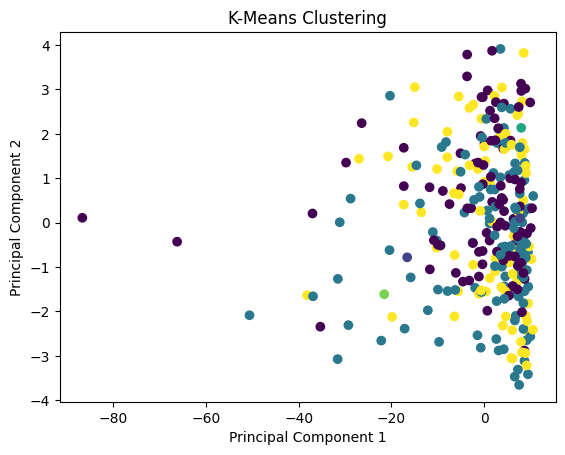

In [ ]:
#visual using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(olmstead_encoded)

# Now use kmeans_labels (which holds the cluster assignments) for coloring the scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
#silhoutte score
kmeans_score = silhouette_score(olmstead_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means: {kmeans_score}")

Silhouette Score for K-Means: -0.03858628134630084


In [ ]:
#adding a column for cluster into the data
olmstead_encoded['cluster'] = kmeans_labels

In [ ]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,5
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,5
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,5
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,2
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
#random forest regressor for invasive species sum
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#creating a column 'invasive_species_sum' based on summing columns 2-16
olmstead_encoded['invasive_species_sum'] = olmstead_encoded.iloc[:, 1:17].sum(axis=1)

In [ ]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster,invasive_species_sum
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,5,20.0
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,5,15.0
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,5,10.0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,2,17.0
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,2,7.0


In [ ]:
olmstead_encoded.iloc[:,1:17]

,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,,ailanthus
0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0,0
1,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0,0
3,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,0,0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0,0
307,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0
308,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,2.0,0,0
309,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0,1


In [ ]:
#splitting the data
X = olmstead_encoded.drop(['cluster', 'invasive_species_sum'], axis=1)
y = olmstead_encoded['invasive_species_sum']

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#random forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestRegressor(random_state=42))
])

In [ ]:
#fitting pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestRegressor(random_state=42))])

In [ ]:
#ypred
y_pred = rf_pipeline.predict(X_test)

In [ ]:
#evaluating model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 6.003556453297658
R-squared: 0.730992847398469


In [ ]:
#evaluating for overfitting
train_score = rf_pipeline.score(X_train, y_train)
test_score = rf_pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.969594134875204
Testing Score: 0.730992847398469


# **Model 2: Apriori Model**

## Version 1: Using Apriori algorithm to find associations between the most common species in the canopy and the understory for Cherokee 2024 + 2021 data

In [ ]:
# importing for apriori
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
apriori_data = pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="Olmstead_combined")

In [ ]:
apriori_data.head()

,trimble station,average_canopy_cover,canopy,understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,Cherokee1,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,Cherokee2,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,Cherokee3,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,Cherokee4,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,Cherokee5,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Removing the word 'Cherokee' from the Trimble station entries that way it is left with just its number
apriori_data['trimble station'] = apriori_data['trimble station'].str.replace('Cherokee', '')

In [ ]:
apriori_data.head()

,trimble station,average_canopy_cover,canopy,understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,1,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,2,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,3,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,4,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,5,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
apriori_data.columns

Index(['trimble station', 'average_canopy_cover', 'canopy', 'understory',
       'Lonicera japonica', 'Microstegium vimineum', 'Euonymus alatus',
       'Ampelopsis brevipedunculata', 'Morus alba', 'Celastrus orbiculatus',
       'Vinca minor', 'Euonymus fortunei', 'Akebia quinata',
       'Fallopia japonica', 'Achyranthes', 'Hederea helix', 'L. maackii',
       'Privet/ Ligustrum', 'Ailanthus'],
      dtype='object')

In [ ]:
#drop all columns except canopy and trimble station
apriori_data = apriori_data.drop(columns=['average_canopy_cover', 'understory',
       'Lonicera japonica', 'Microstegium vimineum', 'Euonymus alatus',
       'Ampelopsis brevipedunculata', 'Morus alba', 'Celastrus orbiculatus',
       'Vinca minor', 'Euonymus fortunei', 'Akebia quinata',
       'Fallopia japonica', 'Achyranthes', 'Hederea helix', 'L. maackii',
       'Privet/ Ligustrum', 'Ailanthus'])

In [ ]:
apriori_data.head()

,trimble station,canopy
0,1,"Walnut, maple, mulberry, locust"
1,2,"Cherry, hackberry, maple"
2,3,"Oak, basswood, maple"
3,4,"Locust, walnut, sycamore"
4,5,"Oak, maple, locust"


In [ ]:
apriori_data.columns

Index(['trimble station', 'canopy'], dtype='object')

In [ ]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }
    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
#apriori_data = apriori_data.apply(clean_canopy_as_list_lowercase)
apriori_data['canopy'] = apriori_data['canopy'].apply(clean_canopy_as_list_lowercase)

In [ ]:
apriori_data.sample(10)

,trimble station,canopy
74,96,"[sugar berry, oak, maple]"
238,NaN,"[sycamore, sugar maple oak, beech]"
134,161,"[maple black cherry, hickory]"
53,69,"[walnut, ash, cherry]"
266,NaN,[maple walnut]
202,NaN,[maple box elder]
261,NaN,[walnut cherry pin oak hackberry hickory maple...
121,148,"[maple walnut, hackberry]"
170,NaN,[sycamore maple declining ash]
127,154,"[walnut, red oak, basswood, sycamore]"


In [ ]:
# drop the empty canopy rows
apriori_data = apriori_data.dropna(subset=['canopy'])


In [ ]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_apriori_data = apriori_data.explode('canopy')
exploded_apriori_data.head(10)

,trimble station,canopy
0,1,walnut
0,1,maple mulberry
0,1,locust
1,2,cherry
1,2,hackberry
1,2,maple
2,3,oak
2,3,basswood
2,3,maple
3,4,locust


In [ ]:
# One-hot encode using pd.crosstab
exploded_apriori_data = pd.crosstab(exploded_apriori_data['trimble station'],exploded_apriori_data['canopy'])
exploded_apriori_data.head(10)

canopy,,ash,bass wood,basswood,beech,black gum,black locust,box elder,boxelder,carpinus,...,sugar maple tulip poplar,sugar maple white oak,sycamore,tree of heaven,tulip polar,tulip poplar,walnut,white,willow oak,yellowwood
trimble station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
101,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
103,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
104,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
105,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
# Apply apriori to find frequent/common species with minimum support 0.10 (species that appeared at least 10% of the time)
common_species = apriori(exploded_apriori_data, min_support=0.10, use_colnames=True)

In [ ]:
common_species

,support,itemsets
0,0.136054,(beech)
1,0.156463,(cherry)
2,0.265306,(hackberry)
3,0.136054,(hickory)
4,0.108844,(maple)
5,0.149660,(oak)
6,0.149660,(sycamore)
7,0.217687,(tulip poplar)
8,0.244898,(walnut)


In [ ]:
# generate association rule from the common species with minimum confidence 0.70 (70% confidence) using num_itemsets
rules = association_rules(common_species, metric='confidence', min_threshold=0.70)
print(rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

TypeError: association_rules() missing 1 required positional argument: 'num_itemsets'

## Version 2: Using Apriori algorithm to find associations between the most common species in the canopy and the understory for Cherokee 2024 data only


In [ ]:
# loading dataset
# using skiprows=1 to skip the first row of the dataset
model_data=pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="2024 Cherokee Invasive Survey", skiprows=1)

In [ ]:
# renaming columns
model_data = model_data.rename(columns={'Comment':'Trimble_station', 'Calculated using formula in densiometer.1':'average_canopy_cover', 'Calculated using formula in densiometer':'form_densiometer'})

# Removing the word 'Cherokee' from the Trimble station entries that wya it is left with just its number
model_data['Trimble_station'] = model_data['Trimble_station'].str.replace('Cherokee', '')

# checking if the entries were changed
model_data.head(5)

,Trimble_station,N,E,S,W,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,...,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,Canopy gap and/or downed trees present,SUM,Dioscorea polystachya,Unnamed: 27
0,1,12.0,3,5,7,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,...,0.0,1.0,3.0,3.0,0.0,0.0,2.0,20,NaN,NaN
1,2,3.0,0,2,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,15,NaN,NaN
2,3,1.0,0,4,5,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,...,0.0,0.0,1.0,3.0,0.0,0.0,1.0,10,NaN,NaN
3,4,13.0,3,4,6,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,...,0.0,4.0,2.0,1.0,0.0,2.0,1.0,19,NaN,1.0
4,5,15.0,12,3,20,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,NaN,NaN


In [ ]:
# deleting uneeded columns
model_data = model_data.drop(['Unnamed: 27', 'N', 'E', 'S', 'W', 'Canopy gap and/or downed trees present', 'Dioscorea polystachya'], axis=1)

#filling out missing values for all columns with 0
model_data.fillna(0, inplace=True)

In [ ]:
# Ensure "Canopy" column entries are strings, replacing NaNs with empty strings
model_data['Canopy'] = model_data['Canopy'].fillna('').astype(str)

# Split species in the canopy column
model_data['Canopy'] = model_data['Canopy'].str.split(', ')

# Ensure "Understory" column entries are strings, replacing NaNs with empty strings
model_data['Understory'] = model_data['Understory'].fillna('').astype(str)

# Split species in the understory column
model_data['Understory'] = model_data['Understory'].str.split(', ')

# Display the processed DataFrame with binary columns
model_data.head(10)

,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,SUM
0,1,7.02,92.98,"[Walnut, maple, mulberry, locust]","[Boxelder, maple, hackberry]",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20
1,2,1.82,98.18,"[Cherry, hackberry, maple]","[Maple, buckeye, locust ]",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15
2,3,2.60,97.40,"[Oak, basswood, maple]","[Maple, ash]",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10
3,4,6.76,93.24,"[Locust, walnut, sycamore]","[Ash, hackberry, boxelder]",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19
4,5,13.00,87.00,"[Oak, maple, locust ]","[Ash, hackberry, viburnum]",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
5,6,1.82,98.18,"[Sycamore, hackberry, cottonwood ]","[Dogwood, hickory, boxelder]",3.0,0.0,0.0,2.0,2.0,...,0.0,3.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,16
6,7,7.28,92.72,"[Sycamore, tulip poplar]","[Dogwood, elm, ash]",0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
7,8,7.54,92.46,"[Locust, hackberry]","[Hackberry, locust, maple, ash]",1.0,2.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,4.0,3.0,4.0,0.0,0.0,21
8,9,7.02,92.98,"[Locust, pine, hackberry]","[Devils walking stick, hackberry]",4.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,17
9,10,1.04,98.96,"[Sycamore, walnut, elm ]","[Boxelder, hackberry]",1.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,10


In [ ]:
model_data.columns

Index(['Trimble_station', 'form_densiometer', 'average_canopy_cover', 'Canopy',
       'Understory', 'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus', 'SUM'],
      dtype='object')

In [ ]:
# drop all columns except canopy, understory, and trimble station
model_data = model_data.drop(columns=['form_densiometer','average_canopy_cover', 'Understory',
       'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus', 'SUM'])

In [ ]:
model_data.sample(10)

,Trimble_station,Canopy
138,165,"[Sugar maple, white oak, walnut, ash]"
99,124,"[Beech, maple, red oak, ]"
67,86,"[Oak, hackberry, maple]"
31,43,"[Sycamore, tulip poplar, oak]"
79,101,"[Walnut, tulip poplar, ash, ]"
100,125,"[Dead ash, walnut, basswood, hickory, ]"
98,121,"[Beech, maple, tulip poplar]"
30,42,"[Tulip poplar, walnut ]"
125,152,"[Tulip poplar, cherry]"
78,100,"[Sugar maple, cherry, walnut, hickory]"


In [ ]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_model_data = model_data.explode('Canopy')
exploded_model_data.head(10)

,Trimble_station,Canopy
0,1,Walnut
0,1,maple
0,1,mulberry
0,1,locust
1,2,Cherry
1,2,hackberry
1,2,maple
2,3,Oak
2,3,basswood
2,3,maple


In [ ]:
# One-hot encode using pd.crosstab
exploded_model_data = pd.crosstab(exploded_model_data['Trimble_station'],exploded_model_data['Canopy'])
exploded_model_data.head(10)

Canopy,,,Basswood,Beech,Box elder,Boxelder,"Carpinus,",Cherry,Chestnut oaks,Dead ash,...,serviceberry,sugar maple,sycamore,sycamore,tulip poplar,tulip poplar,walnut,walnut,white,white oak
Trimble_station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
101,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
104,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
# Apply apriori to find frequent/common species with minimum support 0.10 (species that appeared at least 10% of the time)
common_species = apriori(exploded_model_data, min_support=0.10, use_colnames=True)

In [ ]:
# generate association rule from the frequent items with minimum confidence 0.70 (70% confidence) using num_itemsets
rules = association_rules(common_species, metric='confidence', min_threshold=0.70)
print(rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

TypeError: association_rules() missing 1 required positional argument: 'num_itemsets'

# **Model 3: Random Forest Classification Model**

## Classifying the data based on level of invasive presence for 2024 data

In [ ]:
# load data
# create sum column
# create features and target variable where the sum is the target
# split the data
# use standard scalar and one hot encoder
# train and fit the data
# evaluate model